# Word embedding using tf-idf matrices

This notebook uses tf-idf matrices to create word embeddings for companies. 

Tf-Idf stands for _term frequency - inverse document frequency_. Each row in this matrix represents one document (in this case, one company) and each column represents a word (or n-gram, a sequence of words like "University of Toronto"). A term frequency matrix has the count of occurences of a given word for each document, while a tf-idf matrix performs a transformation on that term frequency matrix. The computation for each cell uses:

\begin{align*}
\text{tf-idf}(t,d) &= \text{tf}(t,d) \cdot \text{idf}(t,d)\\ \\
\text{Where: } \quad \text{tf}(t,d) &= |t| \text{ in } d\\ \\
\text{idf}(t,d) &= \log\frac{N}{\text{df}(t)}\\
\end{align*}

- Where **t** is the current term we are process, and **d** is the current document we are looking in
- Where **N** is the total number of documents in the document set and **df(t)** is the document frequency of t;
    - The document frequency is the number of documents in the document set that contain the term t  
^ From [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)



In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

df = pd.read_csv("../data/preprocessed.csv")
pipe = Pipeline([('count', CountVectorizer(ngram_range = (2,4),
                                           stop_words = 'english', max_features = 400)),
                  ('tfidf', TfidfTransformer())]).fit(df)

In [5]:
# The 400 n-tuples selected as our features based on how many documents theyve appeared in
feature_names = pd.DataFrame(pipe['count'].get_feature_names_out())
feature_names

,0
0,com spec
1,com spec v1
2,git lfs
3,git lfs github
4,git lfs github com
5,github com
6,github com spec
7,github com spec v1
8,https git
9,https git lfs


In [87]:
# The tf-idf matrix
tfidf =  pd.DataFrame(pipe.transform(df_1).toarray())
tfidf

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.088257,0.065122,0.066035,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.0,0.000000,0.031680,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.033352,0.033577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.062709,0.000000,0.000000,0.046271,0.046920,0.141121,0.000000,0.000000,0.054886,0.063132
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.061095,0.000000,0.000000,0.068745,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,0.0,0.0,0.009619,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.015219,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
276,0.0,0.0,0.042983,0.000000,0.012902,0.018675,0.000000,0.0,0.0,0.0,...,0.017002,0.017116,0.000000,0.000000,0.000000,0.000000,0.075270,0.085066,0.074404,0.085582
277,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
278,0.0,0.0,0.004762,0.000000,0.038594,0.000000,0.057974,0.0,0.0,0.0,...,0.005651,0.000000,0.000000,0.004170,0.004228,0.000000,0.004170,0.004712,0.000000,0.000000


In [9]:
# !pip3 install plotly

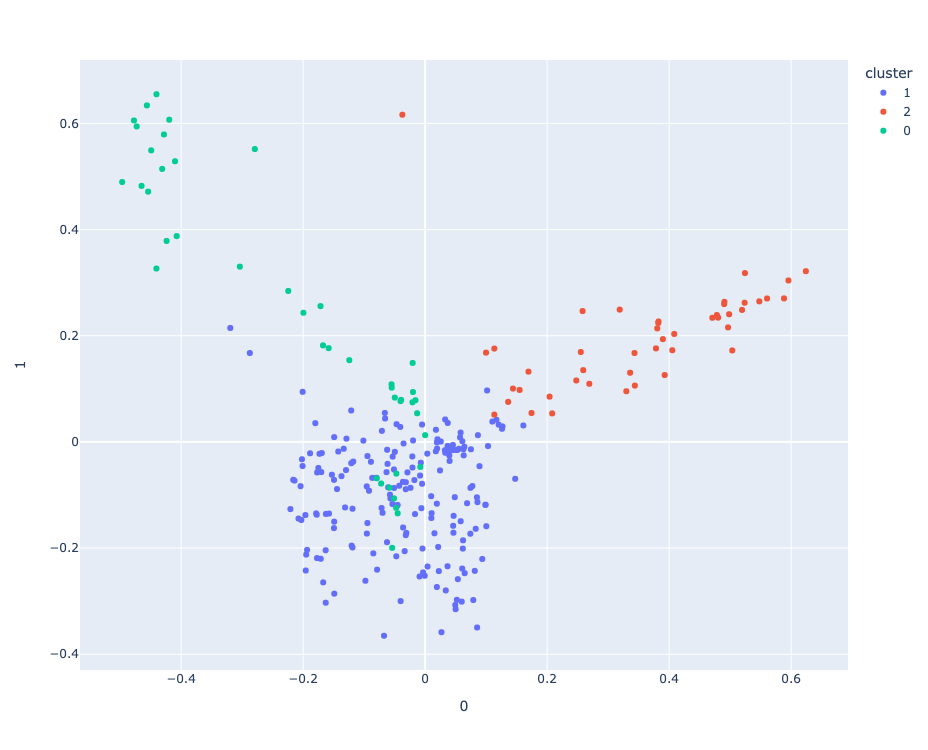

In [88]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# Referenced from my CSCD25 course
def visualize(vectors, index):
    pca = PCA(n_components = 10)
    pca_embedding = pca.fit_transform(vectors)
    pca_embedding = pd.DataFrame(pca_embedding, index = index)
    
    kmeans = KMeans(n_clusters = 3).fit(vectors)
    pca_embedding['cluster'] = kmeans.labels_
    pca_embedding['cluster'] = pca_embedding['cluster'].astype('category')
    
    fig = px.scatter(pca_embedding, x =0 , y = 1, hover_data={"name": pca_embedding.index}, color = 'cluster', width=1200, height=750)
    fig.show()
    
    return [pca, pca_embedding]

plot = visualize(tfidf, np.arange(0,len(tfidf)))

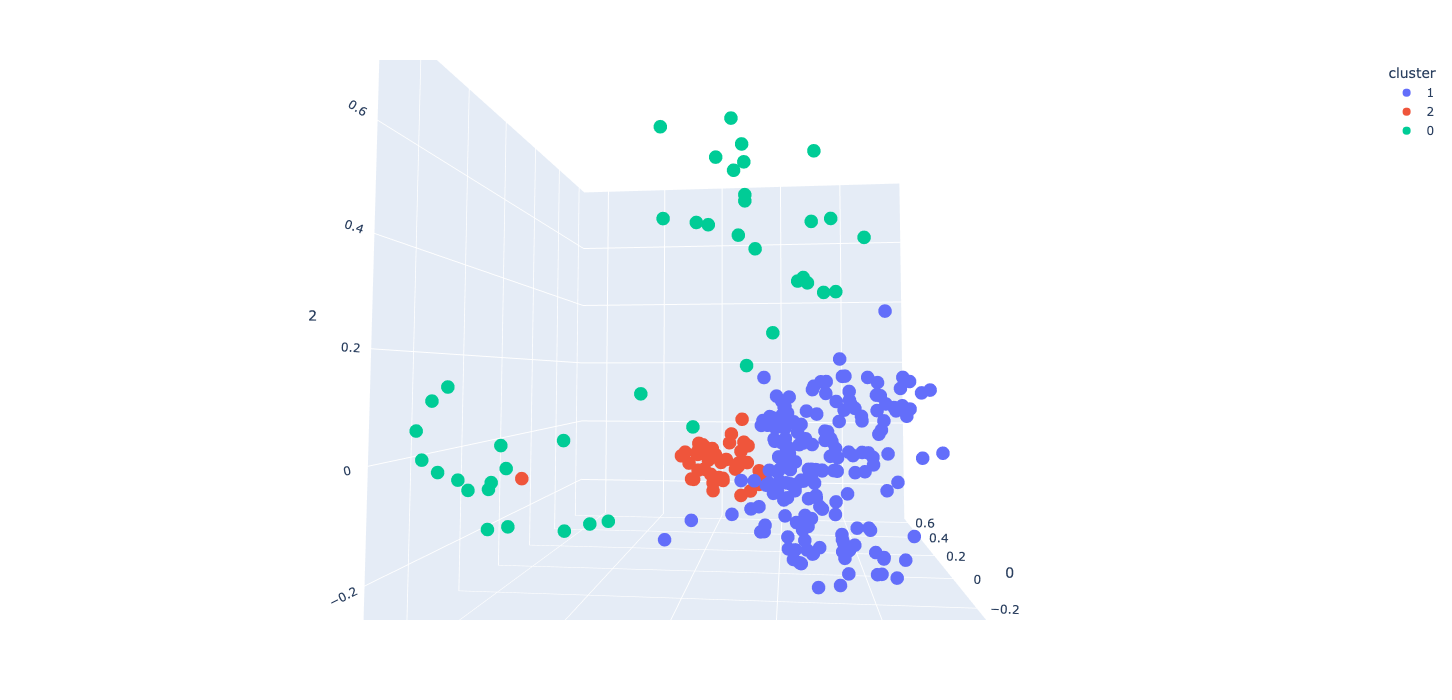

In [89]:
fig = px.scatter_3d(plot[1], x =0 , y = 1, z = 2, hover_data={"name": plot[1].index}, color = 'cluster', width=1200, height=700)
fig.show()

It's hard to tell whether this did a good job at clustering/visualizing groupings of companies since we don't have information on what company names are or sectors they operate in. 

From this plot it does seem as though companies are spread along one major axis, with a large grouping in the bottom left. We don't see any distinct groupings.

In [90]:
# From the explained variance ratio, we see that the top three dimensions don't actually explain that much of the variation that exists within our data/companies.
plot[0].explained_variance_ratio_

array([0.04833637, 0.04409771, 0.04064634, 0.03407688, 0.03167105,
       0.02941252, 0.02650908, 0.02466904, 0.02359351, 0.02018053])

In [91]:
plot[0].explained_variance_ratio_[0:3].sum()

0.13308042157022962

Based on the above, the top three principle components only explain 13% of the total variance that exists within the data.

In [92]:
components = pd.DataFrame(plot[0].components_, columns = feature_names)
components.reindex(components.abs().sort_values(0, axis = 1).index)
# components[0:2]

,"(accounting principles,)","(accounts receivable,)","(act amended,)","(additional information,)","(adverse effect,)","(adverse effect business,)","(adversely affect,)","(advisory agreement,)","(allowance loan,)","(allowance loan losses,)",...,"(wide range,)","(wide variety,)","(working capital,)","(www sec,)","(www sec gov,)","(year end,)","(year ended,)","(year ended december,)","(years ended,)","(years ended december,)"
0,0.006470,-0.006772,0.008198,-0.002318,-0.012431,-0.010977,-0.008419,0.018740,0.068304,0.055180,...,-0.032378,-0.023376,0.001783,-0.019092,-0.017355,-0.002897,-0.037650,-0.030932,-0.025046,-0.024312
1,-0.013198,-0.010992,-0.014688,0.015369,-0.011379,-0.019277,-0.000488,0.004078,0.036409,0.030242,...,0.006160,0.004592,-0.012428,-0.003802,-0.005438,-0.016211,-0.046579,-0.032681,-0.001621,-0.001050
2,-0.002832,-0.009313,-0.003083,-0.016985,-0.021801,-0.017821,-0.011402,-0.003371,-0.012740,-0.009591,...,-0.032162,-0.029349,-0.008157,-0.034743,-0.034268,-0.009347,0.027141,0.030491,-0.015484,-0.014777
3,0.034044,0.022810,0.015171,-0.009822,-0.019405,-0.006942,-0.010666,0.005052,-0.006870,-0.006814,...,-0.014301,-0.019350,0.029730,-0.019190,-0.021488,-0.006213,0.033414,0.042206,-0.001243,-0.006204
4,0.005283,-0.018782,-0.000247,0.005930,0.033777,0.005538,0.019218,0.039887,-0.043444,-0.033267,...,-0.011943,-0.006310,0.017376,0.019066,0.019789,0.007221,0.039906,0.042394,0.018498,0.001014
5,-0.020731,-0.041014,-0.005040,-0.002967,-0.026685,-0.013933,-0.019212,0.002748,0.004622,0.005203,...,-0.014753,-0.004562,-0.033241,-0.016935,-0.015132,0.007231,-0.099232,-0.119681,-0.046064,-0.046958
6,-0.012003,-0.012581,-0.002198,-0.007489,-0.005895,-0.005114,-0.010907,0.001852,-0.040011,-0.031680,...,-0.009879,-0.001172,-0.019481,-0.018046,-0.016508,0.006102,-0.098120,-0.085637,-0.032188,-0.022966
7,-0.017772,0.003045,0.017263,0.003591,-0.016653,-0.017887,-0.024880,0.010059,-0.012015,-0.012577,...,0.007623,0.014244,-0.019350,0.033271,0.030338,0.013648,-0.149633,-0.138112,-0.049106,-0.047638
8,-0.003852,-0.016592,-0.004916,0.009228,0.008393,0.012574,0.016136,0.009808,-0.000142,-0.000307,...,-0.029222,-0.037860,-0.032379,-0.071382,-0.068058,-0.038491,-0.108597,-0.115725,-0.040948,-0.043073
9,-0.019550,0.005222,-0.017324,0.012494,-0.059338,-0.027942,-0.039279,0.001269,0.008673,0.009139,...,-0.004599,-0.014275,-0.011259,-0.014470,-0.013365,-0.017744,0.153852,0.173077,0.035003,0.041711


In [94]:
components.abs().sort_values(2, axis = 1, ascending = False)

,"(vice president,)","(real estate,)","(senior vice,)","(senior vice president,)","(common stock,)","(forward looking,)","(looking statements,)","(forward looking statements,)","(executive vice president,)","(president chief,)",...,"(life insurance,)","(benchmark oil futures,)","(oil futures contract,)","(benchmark oil futures contract,)","(benchmark oil,)","(economic conditions,)","(income tax,)","(oil futures,)","(policies procedures,)","(sales marketing,)"
0,0.389083,0.396763,0.149741,0.149678,0.047284,0.010499,0.013816,0.013003,0.090119,0.095461,...,0.017143,0.001164,0.001138,0.001072,0.000852,0.017656,0.023193,0.001399,0.015948,0.063999
1,0.542043,0.257762,0.218096,0.216948,0.183773,0.171128,0.162269,0.151321,0.127885,0.127290,...,0.000411,0.000262,0.000256,0.000241,0.000162,0.000150,0.000125,0.000075,0.000073,0.000027
2,0.002793,0.163965,0.002932,0.003118,0.055169,0.052592,0.055335,0.051993,0.007160,0.004746,...,0.004871,0.003484,0.003405,0.003207,0.004694,0.002582,0.009106,0.008652,0.006371,0.057766
3,0.263409,0.004356,0.108215,0.107731,0.148378,0.301782,0.300431,0.280328,0.054089,0.080741,...,0.012122,0.001535,0.001500,0.001413,0.002057,0.014165,0.019575,0.004794,0.004188,0.015499
4,0.018013,0.587940,0.002738,0.003591,0.198363,0.133313,0.137924,0.128921,0.000207,0.008085,...,0.025129,0.003209,0.003136,0.002953,0.003153,0.003821,0.048252,0.004245,0.007591,0.023662
5,0.110155,0.110822,0.042549,0.042375,0.165646,0.218538,0.229664,0.211395,0.024397,0.049369,...,0.010306,0.002906,0.002840,0.002675,0.002694,0.020493,0.030576,0.003431,0.006890,0.007525
6,0.119927,0.047336,0.041591,0.041379,0.230996,0.113208,0.113291,0.104039,0.029052,0.049834,...,0.039789,0.006613,0.006463,0.006087,0.006252,0.001428,0.009403,0.009752,0.007574,0.007465
7,0.028995,0.201303,0.013885,0.014323,0.179070,0.277584,0.281651,0.259860,0.007340,0.033020,...,0.004860,0.004085,0.003992,0.003760,0.004180,0.003334,0.002666,0.007255,0.017348,0.003521
8,0.156233,0.169083,0.066866,0.065955,0.075628,0.123427,0.139021,0.134931,0.035336,0.033666,...,0.012411,0.002240,0.002189,0.002061,0.002288,0.000170,0.002463,0.003526,0.003252,0.033170
9,0.042947,0.132741,0.017220,0.016750,0.137332,0.011665,0.024301,0.023797,0.017066,0.004885,...,0.012571,0.001893,0.001850,0.001742,0.001950,0.003818,0.023271,0.000152,0.010212,0.024119


need to find a way to remove common words from the representation

perhaps remove words that exist in more than half the documents?

